# Otsu Method

Ada 2 cara metode otsu untuk mendapatkan *threshold* yang optimal: memanfaatkan *within-class variance* atau *between-class variance*

Perbedaannya adalah terletak pada pemilihan varians-nya. Pada *within-class* varians, dipilih varians terkecil. Sementara untuk *betwee-class* variance memilih varians terbesar.

## Within-class Variance

$$\sigma_W^2 = W_b\sigma_b^2 + W_f\sigma_f^2$$

Dimana:
- $W_b$ adalah bobot dari *background* dan $W_f$ adalah bobot dari *foreground* (persentase piksel pada masing-masing grup).
- $\sigma_b^2$ adalah varian dari *background* dan $\sigma_f^2$ adalah varian dari *foreground*. Nilai ini merepresentasikan seberapa menyebarnya intensitas piksel dalam grup tersebut.

## Between-class Variance

$$\sigma_B^2 = W_b W_f (\mu_b - \mu_f)^2$$

Dimana:
- $W_b$ dan $W_f$ adalah bobot *background* dan *foreground*.
- $\mu_b$ dan $\mu_f$ adalah rata-rata untuk *background* dan *foreground*
- $(\mu_b - \mu_f)^2$ perbedaan rata-rata dari masing-masing grup. Nilai ini perlu dimaksimalkan.

## Threshold dari kedua metode

Masing-masing akan menghasilkan threshold yang sebenarnya sama tapi beda representasi. Hal ini bisa dijelaskan dengan analogi pagar.\
Katakanlah *Between-class Variance* menunjukan *threshold* adalah 140, sedangkan *Within-class Variance* menunjukan *threshold* adalah 139.

Maksudnya adalah, dalam metode *within-class variance*, nilai 0-139 adalah *background*; dalam *between-class variance*, nilai 140-(seterusnya) adalah *foreground*.

# Otsu Method dengan Within-Class Variance

Untuk sekarang, akan dipilih metode *within-class* sebagai demonstrasi segmentasi

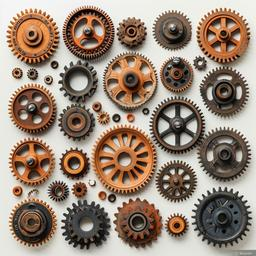

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def otsu_from_scratch(image):
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    total_pixels = image.shape[0] * image.shape[1]
    hist_norm = hist / total_pixels
    intensity_levels = np.arange(256)

    min_within_class_variance = float('inf')
    optimal_threshold = 0

    # Iterate through all possible thresholds
    for t in range(1, 255):
        # --- Background calculations ---
        bg_weight = np.sum(hist_norm[:t])
        if bg_weight == 0:
            continue

        # Calculate background mean and variance
        bg_mean = np.sum(intensity_levels[:t] * hist_norm[:t]) / bg_weight
        bg_variance = np.sum(((intensity_levels[:t] - bg_mean) ** 2) * hist_norm[:t]) / bg_weight

        # --- Foreground calculations ---
        fg_weight = np.sum(hist_norm[t:])
        if fg_weight == 0:
            continue

        # Calculate foreground mean and variance
        fg_mean = np.sum(intensity_levels[t:] * hist_norm[t:]) / fg_weight
        fg_variance = np.sum(((intensity_levels[t:] - fg_mean) ** 2) * hist_norm[t:]) / fg_weight

        # --- Calculate total within-class variance ---
        within_class_variance = (bg_weight * bg_variance) + (fg_weight * fg_variance)

        if within_class_variance < min_within_class_variance:
            min_within_class_variance = within_class_variance
            optimal_threshold = t

    return optimal_threshold

In [ ]:
def calculate_metrics(prediction, ground_truth):
    _, pred_bin = cv2.threshold(prediction, 127, 255, cv2.THRESH_BINARY)
    _, gt_bin = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)

    pred_bool = pred_bin == 255
    gt_bool = gt_bin == 255

    TP = np.sum(np.logical_and(pred_bool, gt_bool))
    TN = np.sum(np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool)))
    FP = np.sum(np.logical_and(pred_bool, np.logical_not(gt_bool)))
    FN = np.sum(np.logical_and(np.logical_not(pred_bool), gt_bool))

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

    return accuracy, iou

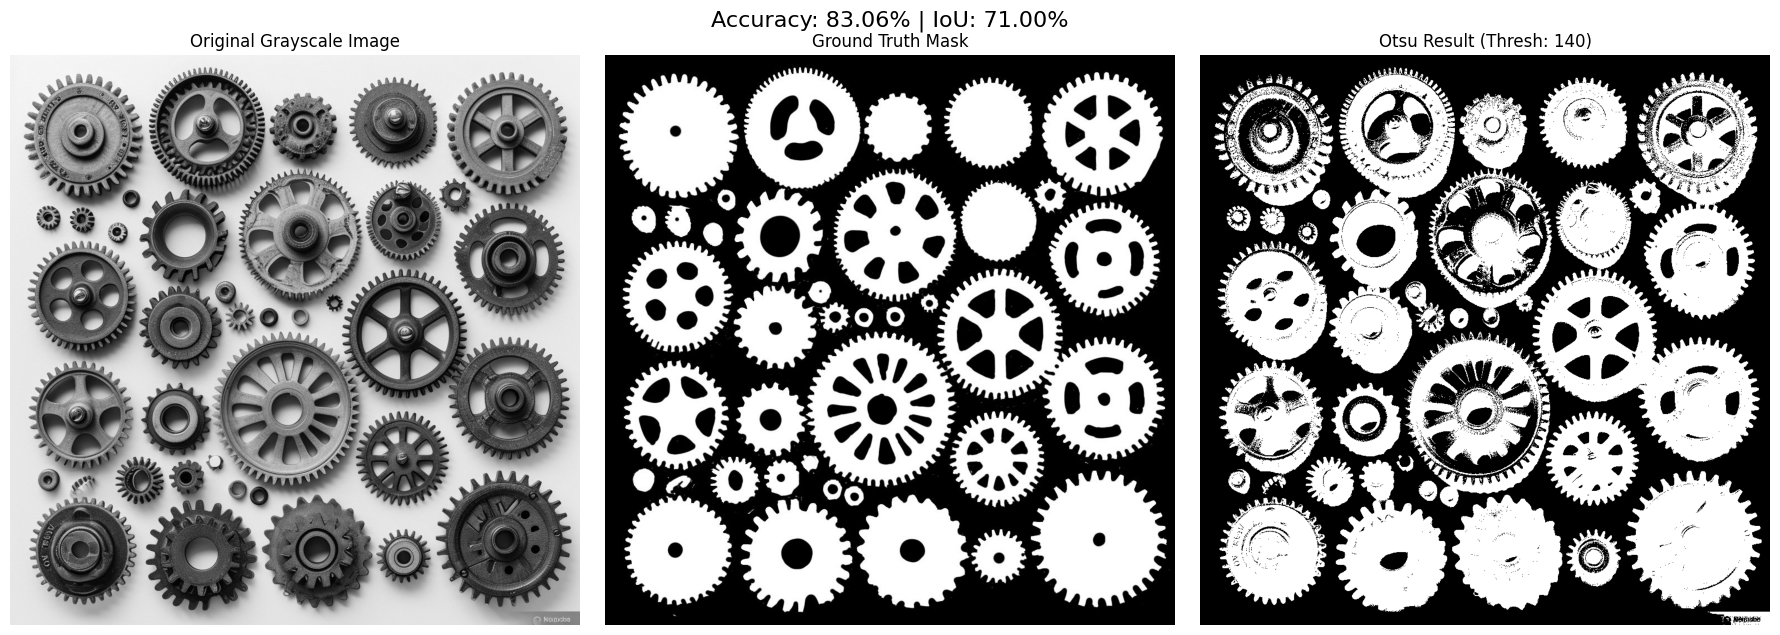

In [ ]:
image_path = 'Image_otsu.jpg'
ground_truth_path = 'Image_gt_Inv.jpg'

original_image = cv2.imread(image_path)
gt_image = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

if original_image is None or gt_image is None:
    print("Error: Could not load one or both images.")
else:
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    threshold_value = otsu_from_scratch(gray_image)

    ret, binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY_INV)

    accuracy, iou = calculate_metrics(binary_image, gt_image)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(gray_image, cmap='gray')
    axes[0].set_title('Original Grayscale Image')
    axes[0].axis('off')

    axes[1].imshow(gt_image, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(binary_image, cmap='gray')
    axes[2].set_title(f'Otsu Result (Thresh: {threshold_value})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Accuracy: {accuracy:.2%} | IoU: {iou:.2%}", fontsize=16, y=1.05)
    plt.show()

## Analisis

Dengan menggunakan *threshold* 140, ditemukan akurasi 83.06% dan IoU 71%. Tapi apakah benar threshold 140 adalah *threshold* terbaik?

# Penentuan *Threshold* dengan menggunakan IoU Terbaik dan Akurasi Terbaik

Jika dalam proses segmentasi tidak memiliki *ground truth*, maka menggunakan varian terkecil dari *Within-class variance* sudah cukup. Namun, jika menggunakan *ground truth* maka yang memiliki IoU terbesarlah yang terbaik.

Ada 4 komponen dasar dalam penghitungan akurasi dan IoU:
- **True Positive (TP):** piksel yang dengan tepat memprediksi *foreground*.
- **True Negative (TN):** piksel yang dengan tepat memprediksi *background*.
- **False Positive (FP):** piksel yang tecara tidak tepat diprediksi sebagai *foreground* (*background* dianggap sebagai *foreground*).
- **False Negative (FN):** pikel yang secara tidak tepat diprediksi sebagai *background* (piksel *foreground* dianggap sebagai *background*).

## Akurasi
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

Akurasi mengukur persentase keseluruhan piksel yang dianggap benar. Dengan begitu, akurasi bisa dianggap sebagai metrik yang kurang tepat, karena jika suatu gambar memiliki *background* yang lebih besar, maka pasti memiliki nilai akurasi yang tinggi.

## IoU
$$\text{IoU} = \frac{\text{Intersection}}{\text{Union}} = \frac{TP}{TP + FP + FN}$$

IoU (Intersection over Union) lebih fokus pada objek (*foreground*) dan tidak akan "terdistorsi" oleh nilai prediksi yang besar dari *background*.

In [4]:
import cv2
import numpy as np
import pandas as pd

def calculate_class_variance(hist_norm, start, end, weight):

    if weight == 0:
        return 0
    intensity_levels = np.arange(256)
    class_mean = np.sum(intensity_levels[start:end] * hist_norm[start:end]) / weight
    class_variance = np.sum(((intensity_levels[start:end] - class_mean) ** 2) * hist_norm[start:end]) / weight
    return class_variance

def calculate_metrics(prediction, ground_truth):
    """Calculates accuracy and IoU"""

    _, pred_bin = cv2.threshold(prediction, 127, 255, cv2.THRESH_BINARY)
    _, gt_bin = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)

    pred_bool = pred_bin == 255
    gt_bool = gt_bin == 255

    TP = np.sum(np.logical_and(pred_bool, gt_bool))
    TN = np.sum(np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool)))
    FP = np.sum(np.logical_and(pred_bool, np.logical_not(gt_bool)))
    FN = np.sum(np.logical_and(np.logical_not(pred_bool), gt_bool))

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    return accuracy, iou

def analyze_all_thresholds(image, ground_truth):

    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    total_pixels = image.shape[0] * image.shape[1]
    hist_norm = hist / total_pixels

    results = []

    for t in range(1, 255):
        bg_weight = np.sum(hist_norm[:t])
        bg_variance = calculate_class_variance(hist_norm, 0, t, bg_weight)
        fg_weight = np.sum(hist_norm[t:])
        fg_variance = calculate_class_variance(hist_norm, t, 256, fg_weight)
        within_class_variance = (bg_weight * bg_variance) + (fg_weight * fg_variance)

        ret, prediction_mask = cv2.threshold(image, t, 255, cv2.THRESH_BINARY_INV)
        accuracy, iou = calculate_metrics(prediction_mask, ground_truth)

        results.append({
            'threshold': t, 'within_class_variance': within_class_variance,
            'accuracy': accuracy, 'iou': iou, 'fg_weight': fg_weight,
            'fg_variance': fg_variance, 'bg_weight': bg_weight, 'bg_variance': bg_variance
        })

    df = pd.DataFrame(results)
    return df

# --- Eksekusi ---

image_path = 'Image_otsu.jpg'
ground_truth_path = 'Image_gt_Inv.jpg'

original_image = cv2.imread(image_path)
gt_image = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

if original_image is None or gt_image is None:
    print("Error: Could not load one or both images.")
else:
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    analysis_df = analyze_all_thresholds(gray_image, gt_image)

    df_sorted_by_variance = analysis_df.sort_values(by='within_class_variance', ascending=True)
    df_sorted_by_accuracy = analysis_df.sort_values(by='accuracy', ascending=False)
    df_sorted_by_iou = analysis_df.sort_values(by='iou', ascending=False)

    for df in [df_sorted_by_variance, df_sorted_by_accuracy, df_sorted_by_iou]:
        for col in ['within_class_variance', 'fg_variance', 'bg_variance']: df[col] = df[col].map('{:.2f}'.format)
        for col in ['accuracy', 'iou', 'fg_weight', 'bg_weight']: df[col] = df[col].map('{:.4f}'.format)

    path1 = 'Analysis_Sorted_by_Variance.csv'
    df_sorted_by_variance.to_csv(path1, index=False)
    print(f"File 1 saved: {path1}")

    path2 = 'Analysis_Sorted_by_Accuracy.csv'
    df_sorted_by_accuracy.to_csv(path2, index=False)
    print(f"File 2 saved: {path2}")

    path3 = 'Analysis_Sorted_by_IoU.csv'
    df_sorted_by_iou.to_csv(path3, index=False)
    print(f"File 3 saved: {path3}")

    print("\n--- Top Results ---")
    print("\nBest threshold by MIN Within-Class Variance:")
    print(df_sorted_by_variance.head(5))
    print("\nBest threshold by MAX Accuracy:")
    print(df_sorted_by_accuracy.head(5))
    print("\nBest threshold by MAX IoU:")
    print(df_sorted_by_iou.head(5))

File 1 saved: Analysis_Sorted_by_Variance.csv
File 2 saved: Analysis_Sorted_by_Accuracy.csv
File 3 saved: Analysis_Sorted_by_IoU.csv

--- Top Results ---

Best threshold by MIN Within-Class Variance:
     threshold within_class_variance accuracy     iou fg_weight fg_variance  \
139        140               1123.17   0.8306  0.7100    0.5038      922.54   
138        139               1123.32   0.8291  0.7071    0.5069      944.47   
140        141               1123.52   0.8319  0.7128    0.5007      901.17   
137        138               1123.95   0.8277  0.7042    0.5101      966.96   
141        142               1124.36   0.8334  0.7157    0.4975      879.53   

    bg_weight bg_variance  
139    0.4962     1326.86  
138    0.4931     1307.18  
140    0.4993     1346.48  
137    0.4899     1287.42  
141    0.5025     1366.78  

Best threshold by MAX Accuracy:
     threshold within_class_variance accuracy     iou fg_weight fg_variance  \
169        170               1339.25   0.8527

## Analisis

Dari hasil penghitungan di atas bisa dilihat bahwa:
- Threshold 140 adalah *threshold* yang memegang nilai *within-class variance* terkecil. Lebih cocok untuk *task* yang tidak memiliki *ground truth*
- Threshold 170 adalah *threshold* yang memegang nilai akurasi tertinggi.
- Threshild 177 adalah *threshold* yang memegang nilai IoU terbaik. Metrik yang cocok jika memiliki ground truth.

# Histogram

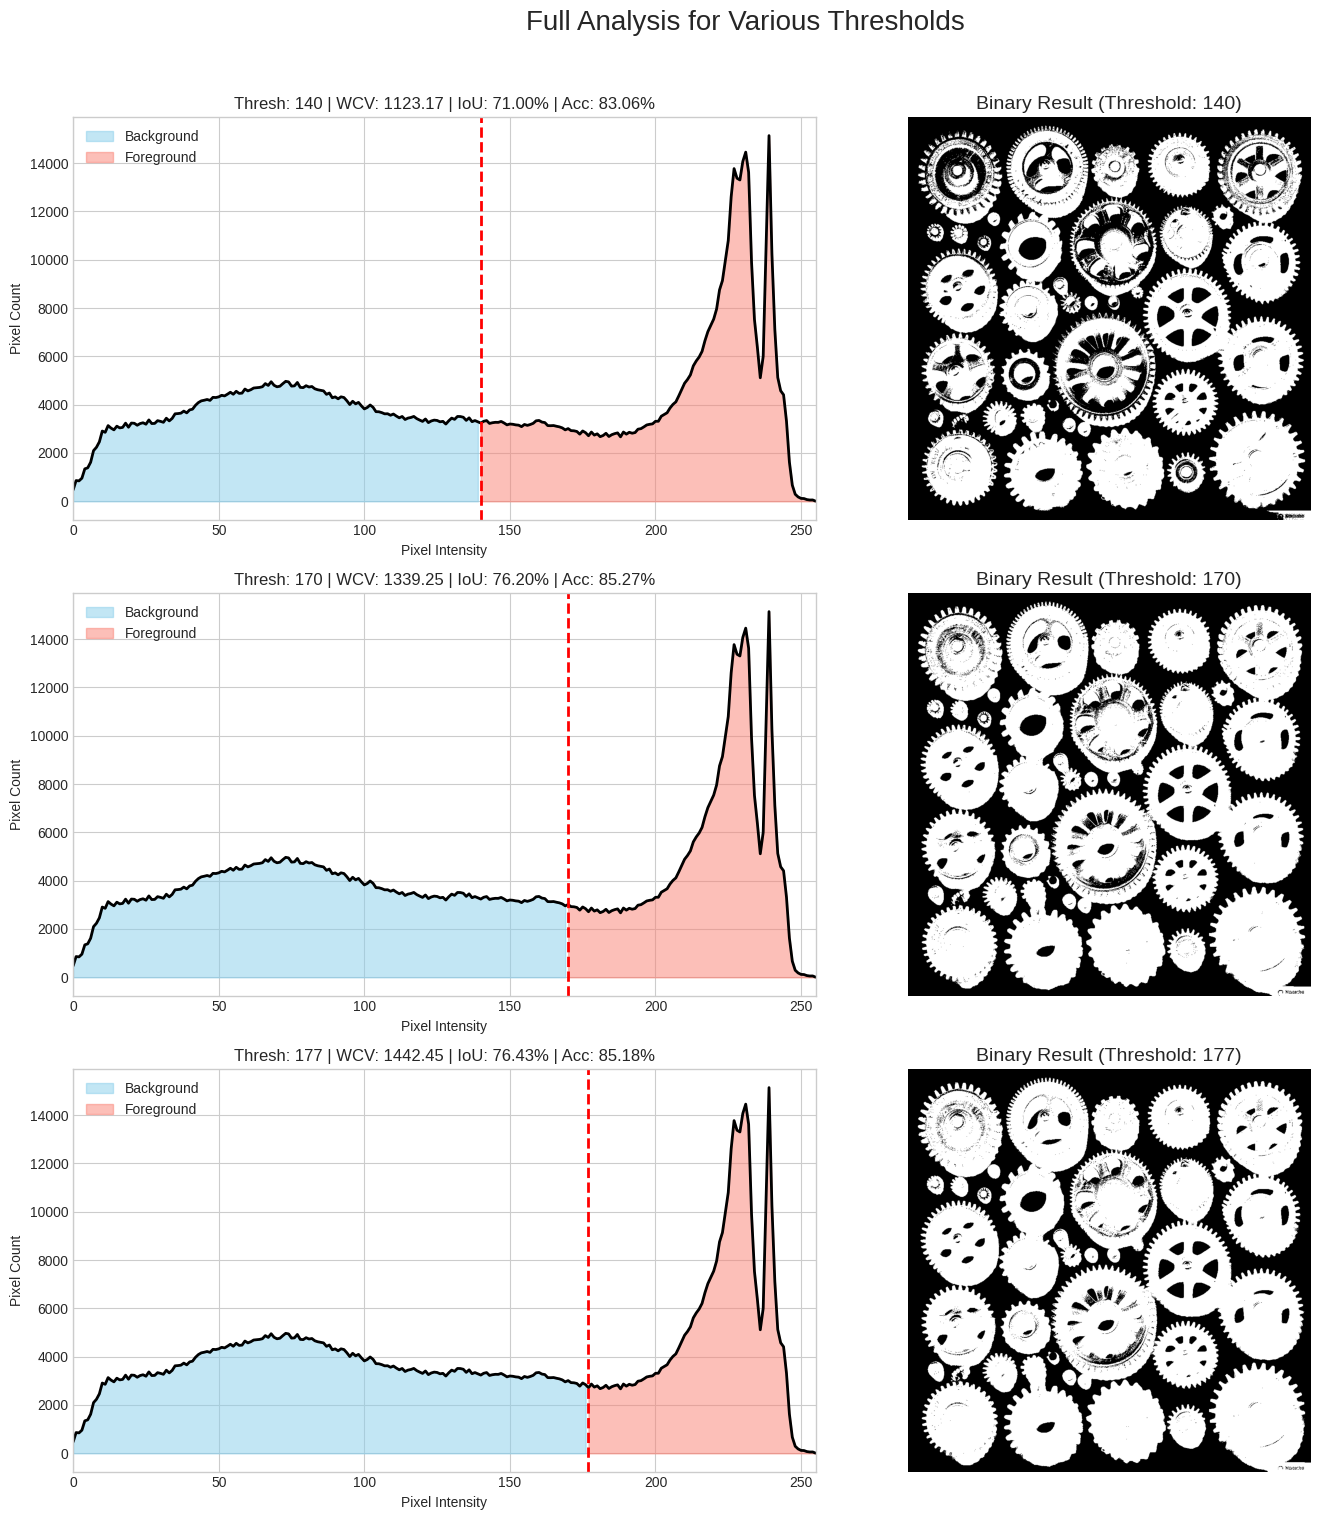

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_within_class_variance(hist_norm, t):
    """Calculates the within-class variance for a single threshold."""
    bg_weight = np.sum(hist_norm[:t])
    if bg_weight == 0:
        return float('inf')

    intensity_levels = np.arange(256)
    bg_mean = np.sum(intensity_levels[:t] * hist_norm[:t]) / bg_weight
    bg_variance = np.sum(((intensity_levels[:t] - bg_mean) ** 2) * hist_norm[:t]) / bg_weight

    fg_weight = np.sum(hist_norm[t:])
    if fg_weight == 0:
        return float('inf')

    fg_mean = np.sum(intensity_levels[t:] * hist_norm[t:]) / fg_weight
    fg_variance = np.sum(((intensity_levels[t:] - fg_mean) ** 2) * hist_norm[t:]) / fg_weight

    within_class_variance = (bg_weight * bg_variance) + (fg_weight * fg_variance)
    return within_class_variance

def calculate_metrics(prediction, ground_truth):
    """Calculates accuracy and IoU"""
    _, pred_bin = cv2.threshold(prediction, 127, 255, cv2.THRESH_BINARY)
    _, gt_bin = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)

    pred_bool = pred_bin == 255
    gt_bool = gt_bin == 255

    TP = np.sum(np.logical_and(pred_bool, gt_bool))
    TN = np.sum(np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool)))
    FP = np.sum(np.logical_and(pred_bool, np.logical_not(gt_bool)))
    FN = np.sum(np.logical_and(np.logical_not(pred_bool), gt_bool))

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    return accuracy, iou

# --- Eksekusi ---

image_path = 'Image_otsu.jpg'
ground_truth_path = 'Image_gt_Inv.jpg'

original_image = cv2.imread(image_path)
gt_image = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

if original_image is None or gt_image is None:
    print(f"Error: Could not load one or both images.")
else:
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    hist, bins = np.histogram(gray_image.flatten(), 256, [0, 256])
    total_pixels = gray_image.shape[0] * gray_image.shape[1]
    hist_norm = hist / total_pixels

    thresholds_to_show = [140, 170, 177]

    fig, axes = plt.subplots(len(thresholds_to_show), 2, figsize=(15, 5 * len(thresholds_to_show)))
    plt.style.use('seaborn-v0_8-whitegrid')

    for i, thresh in enumerate(thresholds_to_show):
        # --- Kalkulasi masing-masing threshold ---
        wcv_score = calculate_within_class_variance(hist_norm, thresh)
        ret, binary_image = cv2.threshold(gray_image, thresh, 255, cv2.THRESH_BINARY_INV)
        accuracy, iou = calculate_metrics(binary_image, gt_image)

        # --- Left Subplot ---
        ax_hist = axes[i, 0]

        ax_hist.plot(hist, color='black', lw=2)
        ax_hist.fill_between(np.arange(thresh), hist[:thresh], color='skyblue', alpha=0.5, label='Background')
        ax_hist.fill_between(np.arange(thresh, 256), hist[thresh:], color='salmon', alpha=0.5, label='Foreground')
        ax_hist.axvline(x=thresh, color='red', linestyle='--', linewidth=2)

        title_text = f'Thresh: {thresh} | WCV: {wcv_score:.2f} | IoU: {iou:.2%} | Acc: {accuracy:.2%}'
        ax_hist.set_title(title_text, fontsize=12)

        ax_hist.set_xlabel('Pixel Intensity', fontsize=10)
        ax_hist.set_ylabel('Pixel Count', fontsize=10)
        ax_hist.set_xlim([0, 255])
        ax_hist.legend()

        # --- Right Subplot ---
        ax_img = axes[i, 1]

        ax_img.imshow(binary_image, cmap='gray')
        ax_img.set_title(f'Binary Result (Threshold: {thresh})', fontsize=14)
        ax_img.axis('off')

    fig.suptitle('Full Analysis for Various Thresholds', fontsize=20, y=1.01)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()